# Lunar Aging Workshop
In this workshop, we will compare the ages of two parts of the moon: the lunar highlands and the lunar maria. The lunar highlands are the light-colored areas on the moon, while the lunar maria are the dark-colored areas. We will use the concept of crater counting to determine the relative ages of the highlands and maria.

### Imports
Here, we import a few packages and load some data to make the code later run smoothly. Just run the cell below to get started!

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ipywidgets as widgets
import matplotlib.patches as patches
from craterpy import CraterDatabase
from PIL import Image
from IPython.display import display

### The Moon
Below is an image of the full moon. Notice that although the Moon is a sphere, here we see it projected as a rectangle- similar to if you peeled an orange and laid the peel flat. The highlands are the light-colored areas, while the maria are the dark-colored areas.

Click the box to show the 8 areas we will be counting craters in. Pick 1 highlands and 1 mare area to count!

Also, try changing the colormap variable to a new value!

In [ ]:
'''
Change the below cells to interact with the code!
Try changing the colormap value
'''

colormap = "gray" # Try changing this "viridis", "inferno", "spring", "Purples", anything!

# Load the image of the Moon
full_moon_path = "./lunar_data/full_moon.tif"
full_moon = Image.open(full_moon_path)

# Load the area coordinates
data_path = "./lunar_data/area_lats_lons.csv"
areas = pd.read_csv(data_path)

# Convert longitudes greater than 180 to the range [-180, 180]
areas['upper_left_lon'] = areas['upper_left_lon'].apply(lambda lon: lon - 360 if lon > 180 else lon)
areas['lower_right_lon'] = areas['lower_right_lon'].apply(lambda lon: lon - 360 if lon > 180 else lon)

# Define lat/lon ranges
min_lat, max_lat = -90, 90
min_lon, max_lon = -180, 180

def plot_moon(show_boxes, colormap):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title("Lunar Surface with Marked Areas")
    
    # Display the image
    ax.imshow(full_moon, cmap=colormap)
    
    # Label axes with lat/lon values
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xticks(np.linspace(0, full_moon.width, 5))
    ax.set_xticklabels(np.round(np.linspace(min_lon, max_lon, 5), decimals=0))
    ax.set_yticks(np.linspace(0, full_moon.height, 5))
    ax.set_yticklabels(np.round(np.linspace(max_lat, min_lat, 5), decimals=0))
    
    # Function to convert lat/lon to image pixel coordinates
    def latlon_to_pixels(lat, lon, img_width, img_height):
        x = ((lon - min_lon) / (max_lon - min_lon)) * img_width
        y = ((max_lat - lat) / (max_lat - min_lat)) * img_height
        return x, y
    
    # Add blue rectangles for each area and label them if enabled
    if show_boxes:
        for _, row in areas.iterrows():
            ul_x, ul_y = latlon_to_pixels(row['upper_left_lat'], row['upper_left_lon'], full_moon.width, full_moon.height)
            lr_x, lr_y = latlon_to_pixels(row['lower_right_lat'], row['lower_right_lon'], full_moon.width, full_moon.height)
            
            width = lr_x - ul_x
            height = lr_y - ul_y
            rect = patches.Rectangle((ul_x, ul_y), width, height, linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)
            
            # Label the area with its number
            ax.text(ul_x + width / 2, ul_y + height / 2, str(int(row['area_number'])), color='white', fontsize=12, ha='center', va='center')
    
    plt.show()

# Create interactive widget
box_toggle = widgets.Checkbox(value=False, description="Display 8 Areas")

# Display the interactive plot
interactive_plot = widgets.interactive(plot_moon, show_boxes=box_toggle, colormap=widgets.fixed(colormap))
display(interactive_plot)

interactive(children=(Checkbox(value=False, description='Display 8 Areas'), Output()), _dom_classes=('widget-i…

### Crater Counting
Now, letʻs zoom in to a few specific areas on the moon. We will count the number of craters in each area to determine the relative ages of the highlands and maria. The highlands are older than the maria, so we expect the highlands to have more craters than the maria.

Change the area number to one the areas above (1-8), and try changing the colormap variable!

In [68]:
'''
Change the below cells to interact with the code!
Try changing the area number and colormap values
'''

area_number = 1 # Try changing this number to 1, 2, 3, 4, 5, 6, 7, 8
colormap = "gray" # Try changing this "viridis", "inferno", "spring", "Purples", anything!

# Define available minimum diameter thresholds
min_diameters = [1, 5, 10, 50, 100]

# Load the data of a specific area
area_path = f"./lunar_data/area_{area_number}.tif"
area_lats_lons = pd.read_csv("./lunar_data/area_lats_lons.csv").iloc[area_number - 1]
min_lat, max_lat = area_lats_lons["lower_right_lat"], area_lats_lons["upper_left_lat"]
min_lon, max_lon = area_lats_lons["upper_left_lon"], area_lats_lons["lower_right_lon"]
craters = pd.read_csv("./lunar_data/reduced_crater_database.csv")
area_craters = craters.loc[(craters.LAT_CIRC_IMG > min_lat) & (craters.LAT_CIRC_IMG < max_lat) & (craters.LON_CIRC_IMG > min_lon) & (craters.LON_CIRC_IMG < max_lon)]

def update_plot(min_diameter, area_path, colormap, area_craters):
    area_craters = area_craters.loc[(area_craters.DIAM_CIRC_IMG > min_diameter)]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8)) 

    # Plot the image with craters
    if not area_craters.empty:
        area_crater_counts = CraterDatabase(area_craters, units="km")
        area_crater_counts.add_annuli(0, 1, 'crater')
        ax = area_crater_counts.plot(ax=ax, lw=0.75, alpha=1, color='tab:red')

    # Plot the image of the area
    im = plt.imread(area_path)
    ax.set_title(f"Lunar Surface of Area {area_number}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    if (min_lon > 180) & (max_lon > 180):
        ax.imshow(im, extent=[min_lon - 360, max_lon - 360, min_lat, max_lat], cmap=colormap)
    else:
        ax.imshow(im, extent=[min_lon, max_lon, min_lat, max_lat], cmap=colormap)
    plt.show()

    print(f"Number of craters with diameter greater than {min_diameter} km: {area_craters.shape[0]}")
    
# Create the interactive slider
style = {'description_width': 'initial'}
slider = widgets.SelectionSlider(
    options=min_diameters,
    value=10,
    description="Minimum Crater Diameter (km):",
    continuous_update=False,
    layout=widgets.Layout(width='1000px', height='50px'),
    style=style
)

# Display the interactive plot
interactive_plot = widgets.interactive(update_plot, min_diameter=slider, area_path=widgets.fixed(area_path), colormap=widgets.fixed(colormap), area_craters=widgets.fixed(area_craters))
display(interactive_plot)

interactive(children=(SelectionSlider(continuous_update=False, description='Minimum Crater Diameter (km):', in…

### Age Calculation

Now, fill in the number of craters above each minimum diameter value in the ```cumulative_crater_counts``` list. The first value in the list is the number of craters with a minimum diameter of 1 km, the 2nd is a minimum diameter of 5 km, the third is 10 km, the 4th is 50 km, and the 5th is 100 km.

In [66]:
'''
Change the below cells to interact with the code!
Change the values of the cumulative_crater_counts
'''

diameters = [1, 5, 10, 50, 100]
cumulative_crater_counts = [0, 0, 0, 0, 0] # Replace 0 with the number of craters for each diameter size!

# Print the number of craters for each diameter size nicely
for diameter, count in zip(diameters, cumulative_crater_counts):
    print(f"Number of craters with diameter greater than {diameter} km: {count}")

Number of craters with diameter greater than 1 km: 0
Number of craters with diameter greater than 5 km: 0
Number of craters with diameter greater than 10 km: 0
Number of craters with diameter greater than 50 km: 0
Number of craters with diameter greater than 100 km: 0


Now, we will use the number of craters of different diameter sizes to date the areas we examined above.

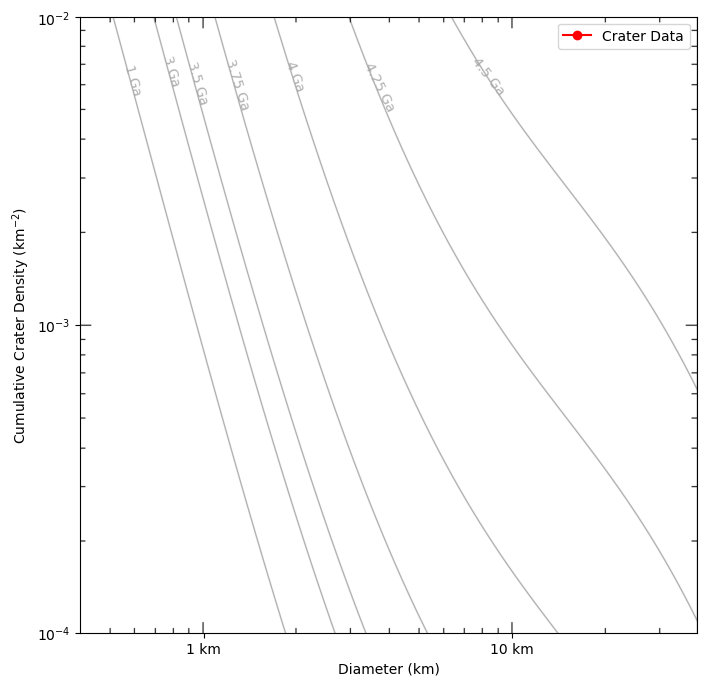

In [67]:
'''
Change the below cells to interact with the code!
Change the color of the dots on the age plot.
'''

dot_color = "red" # Try changing this to "blue", "green", "purple", anything!

# Normalize cumulative crater counts by the reference area
reference_area = 61_500 # km^2
cumulative_count_normalized = np.array(cumulative_crater_counts) / reference_area
mask = np.array(cumulative_count_normalized) > 0
diameters = np.array(diameters)[mask]
cumulative_count_normalized = np.array(cumulative_count_normalized)[mask]

# Load image
image_path = "./lunar_data/age_lines.png"
img = np.asarray(Image.open(image_path))

# Convert pixel positions to log-scale data values
img_height, img_width = img.shape[:2]
x_min, x_max = 10**-0.4, 10**1.6
y_min, y_max = 1e-4, 1e-2
x_ticks = [1, 10]  # Only 1 km and 10 km
y_ticks = [1e-4, 1e-3, 1e-2]  # Only 10^-4, 10^-3, 10^-2
x_pixel_positions = np.interp(np.log10(x_ticks), [np.log10(x_min), np.log10(x_max)], [0, img_width])
y_pixel_positions = np.interp(np.log10(y_ticks), [np.log10(y_min), np.log10(y_max)], [img_height, 0])

# Plot the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img, cmap="gray", origin="upper")

# Plot the crater count data
log_diameters = np.log10(diameters)
log_cumulative_counts = np.log10(cumulative_count_normalized)
diameter_pixel_positions = np.interp(log_diameters, [np.log10(x_min), np.log10(x_max)], [0, img_width])
density_pixel_positions = np.interp(log_cumulative_counts, [np.log10(y_min), np.log10(y_max)], [img_height, 0])
ax.plot(diameter_pixel_positions, density_pixel_positions, color=dot_color, marker='o', label="Crater Data")

# Set custom x and y axes
ax.set_xticks(x_pixel_positions)
ax.set_xticklabels([f"{xt:.0f} km" for xt in x_ticks])
ax.set_yticks(y_pixel_positions)
ax.set_yticklabels([f"$10^{{{int(np.log10(yt))}}}$" for yt in y_ticks]) 
ax.set_xlabel("Diameter (km)")
ax.set_ylabel("Cumulative Crater Density (km$^{-2}$)")
ax.legend()

plt.show()

How old is the area you chose to examine? How does this compare to the age of the other area you examined?

### Conclusion
The number of craters in a given area can be used to determine the relative age of that area. The more craters, the older the area. This is because the Moon has been bombarded by meteorites for billions of years, and older areas have had more time to accumulate craters. The mare are younger than the highlands, because they are areas that were flooded with lava after the highlands had already formed, thus erasing the craters that were there before.